In [4]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import MinMaxScaler
import pickle

np.random.seed(29)


In [5]:
# Scales each feature to lie in [0, 1] and separate the data into training and
# test sets.

def preprocess_data(X, y):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    return [X_train, X_test, y_train, y_test]
    
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [10]:
dataset_names = ['wdbc', 'arrhythmia','DARWIN','CIFAR100']
dataset_arrays = []

data = pd.read_csv('breast+cancer+wisconsin+diagnostic/wdbc.data', header=None).to_numpy()
X = data[:, 2:31]
y = data[:, 1]
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)


data = pd.read_csv('arrhythmia/arrhythmia.data', header=None).replace('?', np.nan).to_numpy()
# Fills in missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imputer.fit_transform(data)
X = data[:, 0:278]
y = data[:, 279]
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)

data = pd.read_csv('DARWIN/data.csv', header=None).replace('?',np.nan).to_numpy()
X=data[1:,1:451]
y=data[1:,451]
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)

data=unpickle("cifar-10-batches-py/data_batch_1")
X=data.get(b"data")
y=data.get(b"labels")
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)

# Returns the dataset with given name
def get_dataset(name):
    i = dataset_names.index(name)
    return dataset_arrays[i]

In [1]:
class Models():

    def __init__(self, modelName, maxIter, L2, nEstimators, bagging, modelTitle):
        """
        modelName: dataset to use
        maxIter: max iterations to train to
        L2: array of L2 regularization, None if no L2 reg.
        nEstimators: array of nEstimators, None if not doing Ensemble
        bagging: Fraction we want to test, None if no bagging
        modelTitle: Title for graphs, what is this model?
        """
        self.modelName=modelName
        self.XTrain,self.XTest,self.yTrain,self.yTest=get_dataset(modelName)
        self.maxIter=maxIter
        self.L2=L2
        self.nEstimators=nEstimators
        self.bagging=bagging
        self.modelTitle=modelTitle
        self.modelResults={}

    def NEst(self, numEst):

        if self.bagging==None:
            return {"Bagging:None":self.BagFrac(None,numEst)}
        else:
            returnDic={}
            returnDic["Bagging:None"]=self.BagFrac(None,numEst)
            for frac in self.bagging:
                returnDic[f"Bagging:{frac}"]=self.BagFrac(frac,numEst)
        return returnDic

    def BagFrac(self, bagfrac,numEst):
        if self.L2==None:
            return {"L2:None":self.L2Reg(None,bagfrac,numEst)}
        else:
            returnDic={}
            returnDic["L2:None"]=self.L2Reg(None,bagfrac,numEst)
            for l2 in self.L2:
                returnDic[f"L2:{l2}"]=self.L2Reg(l2,bagfrac,numEst)
        return returnDic

    def L2Reg(self, l2,bagFrac,numEst):
        if l2==None:
            base = LogisticRegression(penalty=None, max_iter=self.maxIter)
        else:
            base=LogisticRegression(penalty='l2', C=l2, max_iter=self.maxIter)
        if bagFrac==None and numEst==None:
            base.fit(self.XTrain,self.yTrain)
            return {"tr":base.score(self.XTrain, self.yTrain),
                "te":base.score(self.XTest, self.yTest)}
        elif bagFrac==None:
            classifier=BaggingClassifier(estimator=base, 
                                           n_estimators=numEst, 
                                           max_samples=1.0)

            classifier.fit(self.XTrain, self.yTrain)
            return {"tr":classifier.score(self.XTrain, self.yTrain),
                "te":classifier.score(self.XTest, self.yTest)}
        else:
            bagging_classifier = BaggingClassifier(estimator=base, 
                                           n_estimators=numEst, 
                                           max_samples=bagFrac)
            bagging_classifier.fit(self.XTrain, self.yTrain)
            return {"tr":bagging_classifier.score(self.XTrain, self.yTrain),
                "te":bagging_classifier.score(self.XTest, self.yTest)}

    def Train(self):
        """Does logical regression on data, returns training accuracy and test acc.
        can ignore output, saved to obj."""
        self.modelResults["NEst:None"]=self.NEst(None)
        if self.nEstimators!=None:
            for est in self.nEstimators:
                self.modelResults[f"NEst:{est}"]=self.NEst(est)

    def Graph(self,xaxis,include):
        """xAxis can be: NEST, L2, BAG
        include: NEST, L2, BAG, None; but not what was chosen as xaxis.
        """
        print(self.modelResults)
        tr=[]
        te=[]
        if xaxis=="NEST":
            if include=="NEST":
                print("ERROR: xaxis cannot be the same as include")
                return None
            elif include=="L2" and include=="BAG":
                print("Not yet implemented")
                return None
            elif include=="L2":
                return None
            elif include=="BAG":
                return None
            else:
                for nEst in self.nEstimators:
                    tr.append(self.modelResults.get(f"NEst:{nEst}").get("Bagging:None").get("L2:None").get("tr"))
                    te.append(self.modelResults.get(f"NEst:{nEst}").get("Bagging:None").get("L2:None").get("te"))
                plt.plot(self.nEstimators,tr,label="Train")
                plt.plot(self.nEstimators,te,label="Test")

            tr_OneEst=np.full(len(self.nEstimators), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("tr"))
            te_OneEst=np.full(len(self.nEstimators), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("te"))
            plt.plot(self.nEstimators,tr_OneEst,label="Train w/o Bagging, L2, NumEst")
            plt.plot(self.nEstimators,te_OneEst,label="Test w/o Bagging, L2, NumEst")
        elif xaxis=="L2":
            return None
        elif xaxis=="BAG":
            return None
        else:
            print("ERROR: incorrect xaxis value given")
        plt.legend(loc="best")
        plt.title(self.modelTitle)
        plt.xlabel(xaxis)
        plt.ylabel("Accuracy")
        plt.show()




{'NEst:None': {'Bagging:None': {'L2:None': {'tr': 1.0, 'te': 0.5735294117647058}}}, 'NEst:1': {'Bagging:None': {'L2:None': {'tr': 0.875, 'te': 0.5294117647058824}}}, 'NEst:5': {'Bagging:None': {'L2:None': {'tr': 0.9427083333333334, 'te': 0.6323529411764706}}}, 'NEst:10': {'Bagging:None': {'L2:None': {'tr': 0.96875, 'te': 0.6176470588235294}}}, 'NEst:15': {'Bagging:None': {'L2:None': {'tr': 0.9791666666666666, 'te': 0.6323529411764706}}}, 'NEst:20': {'Bagging:None': {'L2:None': {'tr': 0.9921875, 'te': 0.6470588235294118}}}, 'NEst:40': {'Bagging:None': {'L2:None': {'tr': 1.0, 'te': 0.6470588235294118}}}, 'NEst:80': {'Bagging:None': {'L2:None': {'tr': 1.0, 'te': 0.6323529411764706}}}, 'NEst:160': {'Bagging:None': {'L2:None': {'tr': 1.0, 'te': 0.6470588235294118}}}}


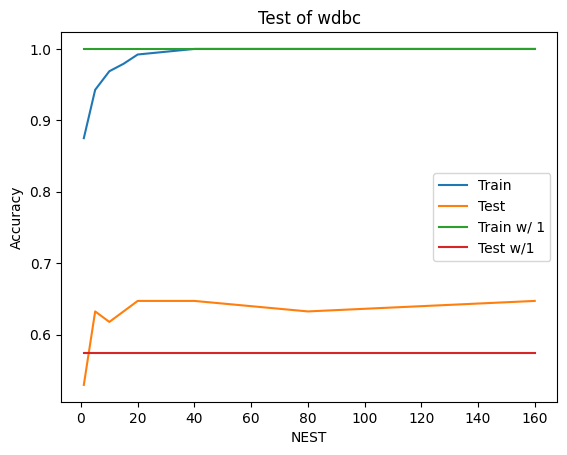

In [15]:
testModel=Models('arrhythmia',10000,None,[1,5,10,15,20,40,80,160],None,"Test of wdbc")
testModel.Train()
testModel.Graph('NEST',None)

In [29]:
# Trains bagging model on top of logistic regression.
def bagging_log_regr(X_train, X_test, y_train, y_test, num_models, frac_samples, regularization=None):
    if (regularization == None):
        base = LogisticRegression(penalty=None, max_iter=5000)
    else:
        base = LogisticRegression(penalty='l2', C=regularization, max_iter=5000)
    bagging_classifier = BaggingClassifier(estimator=base, 
                                           n_estimators=num_models, 
                                           max_samples=frac_samples)
    bagging_classifier.fit(X_train, y_train)
    return bagging_classifier.score(X_train, y_train), bagging_classifier.score(X_test, y_test)

# Plots training and testing accuracy vs. number of base learners.
def plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc):
    plt.plot(list_n_models, list_tr_acc, label='Train')
    plt.plot(list_n_models, list_te_acc, label='Test')
    nobag_tr = np.full(len(list_n_models), nobag_tr_acc)
    nobag_te = np.full(len(list_n_models), nobag_te_acc)
    plt.plot(list_n_models, nobag_tr, label='Train without bagging')
    plt.plot(list_n_models, nobag_te, label='Test without bagging')
    plt.legend(loc='best')
    plt.show()
    

1.0
0.9186046511627907
[0.9710144927536232, 0.9917184265010351, 0.989648033126294, 0.9917184265010351, 0.989648033126294, 0.9937888198757764, 0.9937888198757764]
[0.9418604651162791, 0.9534883720930233, 0.9302325581395349, 0.9418604651162791, 0.9302325581395349, 0.9418604651162791, 0.9418604651162791]


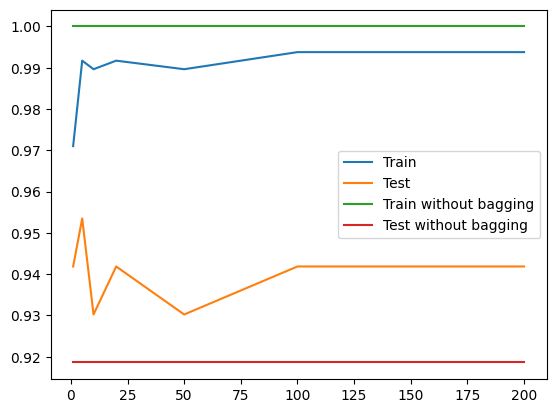

In [30]:
# Test on number of base learners

list_n_models = [1, 5, 10, 20, 50, 100, 200]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_models in list_n_models:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, n_models, 0.5)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

1.0
0.7058823529411765
[0.75, 0.8411458333333334, 0.8645833333333334, 0.8802083333333334, 0.9114583333333334, 0.8828125, 0.8828125]
[0.5294117647058824, 0.6176470588235294, 0.7058823529411765, 0.6911764705882353, 0.7205882352941176, 0.7058823529411765, 0.7205882352941176]


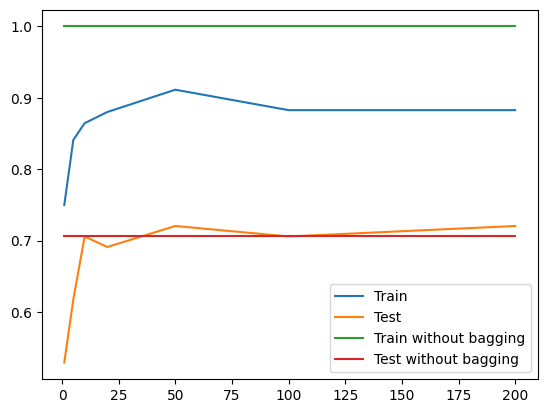

In [31]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)

list_tr_acc = []
list_te_acc = []
for n_models in list_n_models:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, n_models, 0.5)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)


In [32]:
# Plots training and test accuracies vs number of examples used to train each base learners.
def plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc):
    plt.plot(list_n_examples, list_tr_acc, label='Train')
    plt.plot(list_n_examples, list_te_acc, label='Test')
    nobag_tr = np.full(len(list_n_examples), nobag_tr_acc)
    nobag_te = np.full(len(list_n_examples), nobag_te_acc)
    plt.plot(list_n_examples, nobag_tr, label='Train without bagging')
    plt.plot(list_n_examples, nobag_te, label='Test without bagging')
    plt.legend(loc='best')
    plt.show()

1.0
0.9186046511627907
[0.9813664596273292, 0.9855072463768116, 0.9917184265010351, 0.9979296066252588, 0.9958592132505176]
[0.9767441860465116, 0.9534883720930233, 0.9534883720930233, 0.9418604651162791, 0.9302325581395349]


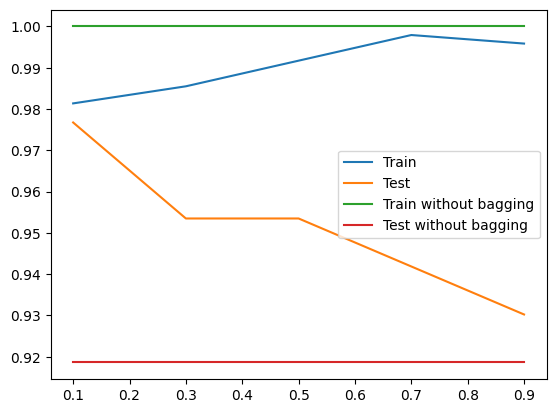

In [33]:
# Test on fraction of examples used to train each base learners

list_n_examples = [0.1, 0.3, 0.5, 0.7, 0.9]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_examples in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, n_examples)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

1.0
0.7058823529411765
[0.6666666666666666, 0.8020833333333334, 0.8697916666666666, 0.9322916666666666, 0.9635416666666666]
[0.6323529411764706, 0.7205882352941176, 0.6911764705882353, 0.6911764705882353, 0.6617647058823529]


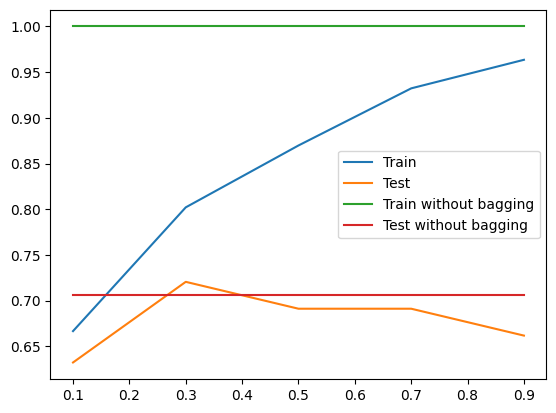

In [34]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_examples in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, n_examples)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

In [35]:
# Plots training and test accuracies vs C (inverse of regularization strength)
def plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc):
    plt.plot(list_C, list_tr_acc, label='Train w/ bagging')
    plt.plot(list_C, list_te_acc, label='Test w/ bagging')
    plt.plot(list_C, list_nobag_tr_acc, label='Train w/o bagging')
    plt.plot(list_C, list_nobag_te_acc, label='Test w/o bagging')
    plt.legend(loc='best')
    plt.show()

[0.9358178053830227, 0.9627329192546584, 0.9751552795031055, 0.9813664596273292, 0.9813664596273292, 0.9855072463768116, 0.9937888198757764, 0.9937888198757764]
[0.9534883720930233, 0.9651162790697675, 0.9651162790697675, 0.9767441860465116, 0.9767441860465116, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233]
[0.9089026915113871, 0.9565217391304348, 0.9606625258799172, 0.979296066252588, 0.9813664596273292, 0.9834368530020704, 0.9855072463768116, 0.989648033126294]
[0.8953488372093024, 0.9534883720930233, 0.9651162790697675, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9651162790697675, 0.9418604651162791]


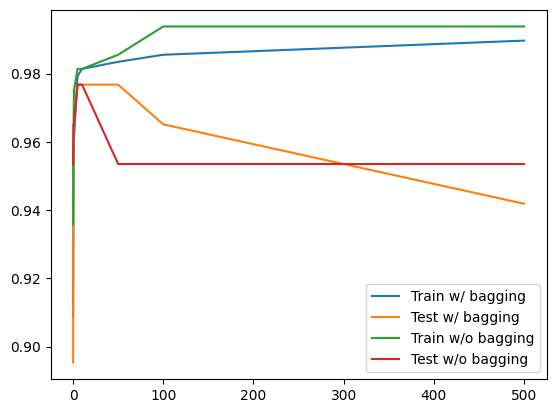

In [36]:
# Test on C

list_C = [0.1, 0.5, 1, 5, 10, 50, 100, 500]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

list_nobag_tr_acc = []
list_nobag_te_acc = []
list_tr_acc = []
list_te_acc = []
for C in list_C:
    log_regr = LogisticRegression(penalty='l2', C=C, max_iter=5000)
    log_regr.fit(X_train, y_train)
    list_nobag_tr_acc.append(log_regr.score(X_train, y_train))
    list_nobag_te_acc.append(log_regr.score(X_test, y_test))
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, 0.5, regularization=C)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_nobag_tr_acc)
print(list_nobag_te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc)

[0.6432291666666666, 0.796875, 0.8385416666666666, 0.9348958333333334, 0.96875, 0.9973958333333334, 1.0, 1.0]
[0.6617647058823529, 0.7205882352941176, 0.7205882352941176, 0.7205882352941176, 0.7352941176470589, 0.6911764705882353, 0.6911764705882353, 0.6911764705882353]
[0.5755208333333334, 0.7005208333333334, 0.7317708333333334, 0.8125, 0.828125, 0.8697916666666666, 0.8619791666666666, 0.90625]
[0.5882352941176471, 0.6617647058823529, 0.6764705882352942, 0.6911764705882353, 0.6911764705882353, 0.7205882352941176, 0.6617647058823529, 0.6764705882352942]


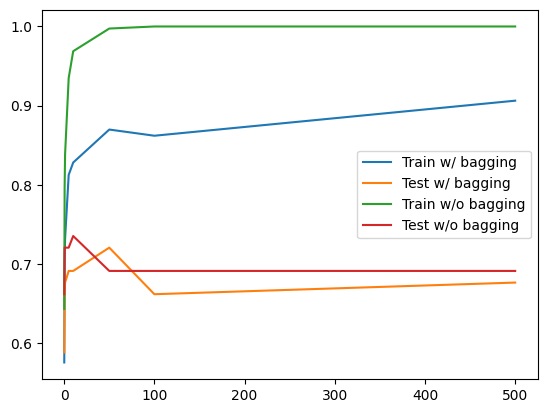

In [37]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

list_nobag_tr_acc = []
list_nobag_te_acc = []
list_tr_acc = []
list_te_acc = []
for C in list_C:
    log_regr = LogisticRegression(penalty='l2', C=C, max_iter=5000)
    log_regr.fit(X_train, y_train)
    list_nobag_tr_acc.append(log_regr.score(X_train, y_train))
    list_nobag_te_acc.append(log_regr.score(X_test, y_test))
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, 0.5, regularization=C)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_nobag_tr_acc)
print(list_nobag_te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc)